In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random_utils import RandomGenerator

# Section 1.1 (Random Number Generation)

- I use numpy.random.default_rng to get the random number generator instance.
- The seed parameter allows for reproducible results, crucial for testing and debugging.
- `get_normal()` can return a single value or a NumPy array of specified size.

In [3]:
RandomGenerator?

Init signature: RandomGenerator(seed=None)
Docstring:     
Provides utilities for random number generation, 
primarily standard normal variables, i.e. N(0,1).
Init docstring:
Initializes the random number generator.
Args:
    seed(int, optional): Seed for the random number
    generator for reproducibility.
    Defaults to None (random seed).
File:           ~/Desktop/QuantProjects/MonteCarloExoticsPy/random_utils.py
Type:           type
Subclasses:     

In [4]:
RandomGenerator().get_normal(size=10)

array([ 0.06239006, -1.01034157,  0.25515308,  0.54165373, -0.06102998,
        1.02074131,  0.39435019, -0.42203916,  0.60404585,  0.534868  ])

In [5]:
RandomGenerator().get_uniform(size=10)

array([0.17918103, 0.34699761, 0.71807017, 0.56754089, 0.2269016 ,
       0.61347673, 0.88253764, 0.46036845, 0.55978696, 0.72894279])

# Section 1.2 (Path Simulation)


- Creates paths.
- `generate_path()`: Generates one path.
- `generate_paths_matrix()`: Generate multiple paths at once. This can be very beneficial for performance if payoff calculations can also be vectorized.

In [6]:
from path_simulator import PathSimulator 

In [7]:
PathSimulator?

Init signature:
PathSimulator(
    initial_price: float,
    risk_free_rate: float,
    dividend_yield: float,
    volatility: float,
    time_to_expiry: float,
    num_steps: float,
    random_generator: random_utils.RandomGenerator,
)
Docstring:      Simulates asset price path using GBM.
Init docstring:
Args:
    initial_price (S0)  : Initial asset price.
    risk_free_rate (r)  : Risk-free interest rate (annualized).
    dividend_yield (q)  : Continuous dividend yield (annualized).
    volatility (sigma)  : Asset price volatility (annualized).
    time_to_expiry (T)  : Time to option expiry in years.
    num_steps           : Number of time steps in the path.
    random_generator    : An instance of RandomGenerator.
File:           ~/Desktop/QuantProjects/MonteCarloExoticsPy/path_simulator.py
Type:           type
Subclasses:     

In [26]:
rng = RandomGenerator()
simulator = PathSimulator(initial_price=100.0, risk_free_rate=0.05, dividend_yield=0.01,
                            volatility=0.2, time_to_expiry=1.0, num_steps=252,
                            random_generator=rng)

single_path = simulator.generate_path()
print("Single Path (first 5 steps):", single_path[:5])
print("Single Path length:", len(single_path))

paths_mat = simulator.generate_paths_matrix(num_paths=3)
print("\nPaths Matrix (first 5 steps for 3 paths):\n", paths_mat[:, :5])
print("Paths Matrix shape:", paths_mat.shape)

Single Path (first 5 steps): [100.         101.45983138 101.14576806 100.6858484  100.55690195]
Single Path length: 253

Paths Matrix (first 5 steps for 3 paths):
 [[100.          99.19796211  99.61857338  99.87939351  97.07499101]
 [100.         100.11929116 100.53756385 100.16303561 102.40678917]
 [100.         100.02581156  97.8683551   95.82253552  94.79996968]]
Paths Matrix shape: (3, 253)


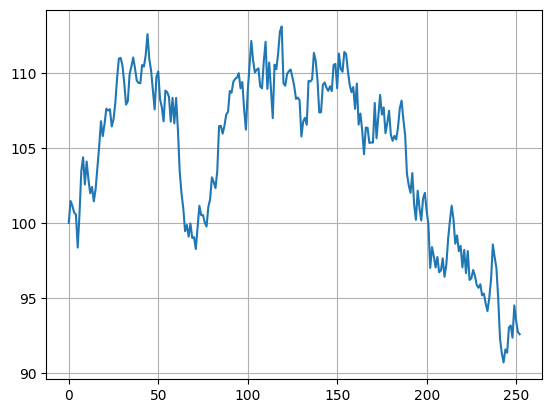

In [27]:
plt.plot(single_path)
plt.grid(True)

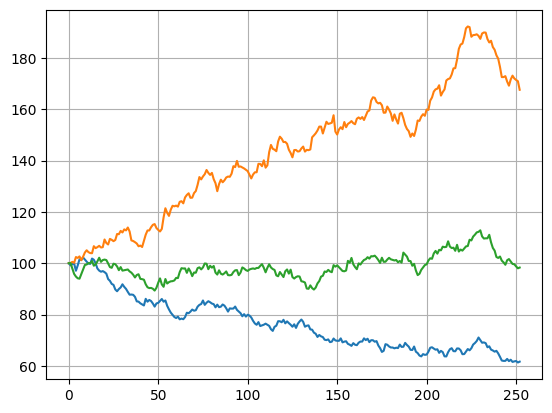

In [28]:
for val in paths_mat:
    plt.plot(val)
plt.grid(True)